# Image Classification using Convolutional Neural Networks, ResNet9 and Transfer Learning in PyTorch



In [1]:
import os
import torch

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import models

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [34]:
!pip install jovian --upgrade -q

import jovian

project_name='intel-image-classification'
jovian.set_project(project_name)
jovian.set_colab_id('1gSua6TfWV4ePd8zs-CcEU2RxY8Xt7pE_')

## Downloading the Dataset

This notebook is an extension to the tutorial [Image Classification using CNNs in PyTorch](https://jovian.ai/aakashns/05-cifar10-cnn), where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 75% accuracy. Here are some images from the dataset:



Let's begin by downloading the dataset and creating PyTorch datasets to load the data, just as we did in the previous tutorial.

### Download using `opendatasets` library

In [3]:
!pip install opendatasets --upgrade --q

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'

od.download(dataset_url)

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [5]:
data_dir = 'intel-image-classification'
print(os.listdir(data_dir))


['seg_pred', 'seg_train', 'seg_test']


In [6]:
train_dir = data_dir + '/seg_train/seg_train/'
test_dir = data_dir + '/seg_test/seg_test/'

classes = os.listdir(train_dir)
print(classes)

num_classes = len(classes)
print(num_classes)

['mountain', 'glacier', 'forest', 'buildings', 'sea', 'street']
6


### Load from local drive

In [ ]:
data_dir = 'data'
print(os.listdir(data_dir))

train_dir = data_dir + '/seg_train/seg_train/'
test_dir = data_dir + '/seg_test/seg_test/'

classes = os.listdir(train_dir)
print(classes)

['Testing', 'Training']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


### Check the data

In [7]:
print("---Training Set---")
for cls in classes:
    print(f"{cls} : {len(os.listdir(train_dir + cls))}")

print("---Test Set---")
for cls in classes:
    print(f"{cls} : {len(os.listdir(test_dir + cls))}")

---Training Set---
mountain : 2512
glacier : 2404
forest : 2271
buildings : 2191
sea : 2274
street : 2382
---Test Set---
mountain : 525
glacier : 553
forest : 474
buildings : 437
sea : 510
street : 501


## Loading data into PyTorch

### Find means and standard deviations

Define `get_mean_and_std` function to calculate the means and standard deviations of the dataset that we will use to normalize.

In [8]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels (dim1)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [10]:
tfms = T.Compose([T.Resize(128), 
                  T.CenterCrop(128), 
                  T.ToTensor()])

dataset = ImageFolder(train_dir, tfms)
dataloader = DataLoader(dataset, 128)

get_mean_and_std(dataloader)

# Mean: tensor([0.4302, 0.4574, 0.4537])
# Std: tensor([0.2580, 0.2562, 0.2884]))

(tensor([0.4302, 0.4574, 0.4537]), tensor([0.2580, 0.2562, 0.2884]))

torch.Size([3, 128, 128]) mountain


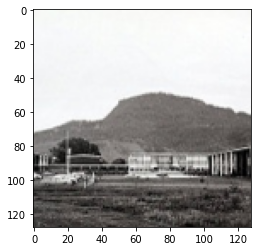

In [11]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print(img.shape, classes[label])

### Load and transform

Load the data using `ImageFolder` with channel-wise data normalization & randomized data augmentations.

In [8]:
img_size = 128
mean = [0.4302, 0.4574, 0.4537]
std = [0.2580, 0.2562, 0.2884]
stats = mean, std

train_tfms = T.Compose([T.Resize(img_size),
                        T.RandomCrop(img_size), 
                        T.ToTensor(),
                        T.Normalize(*stats, inplace=True)])
test_tfms = T.Compose([T.Resize(img_size),
                        T.RandomCrop(img_size),
                        T.ToTensor(),
                        T.Normalize(*stats)])

dataset = ImageFolder(train_dir, train_tfms)
test_ds = ImageFolder(test_dir, test_tfms)

len(dataset), len(test_ds)

(14034, 3000)

Slit the dataset into `train_ds` for training and `valid_ds` for validaton using `random_split` function.

In [9]:
valid_size = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size

train_ds, valid_ds = random_split(dataset, [train_size, valid_size])

len(train_ds), len(valid_ds)

(12631, 1403)

Create data loaders for retrieving images in batches with `batch_size`.

In [10]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [11]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
      images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:batch_size], nrow=16).permute(1, 2, 0).clamp(0, 1))
        break

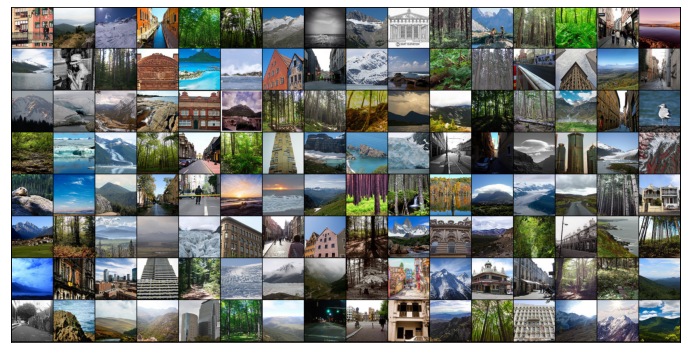

In [33]:
show_batch(train_dl)

## Utitilty Functions

### GPU utilities

- `get_default_device` to choose the `device` we'll use to train our models on (GPU if it is available, otherwise CPU is chosen)
- `to_device` to move tensors including our models to the `device`
- `DeviceDataLoader` to move dataloaders to the `device`

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

So our device is a GPU with the type `'cuda'`.

Now we transfer batches of data from our data loaders to the GPU using the predefined `DeviceDataLoader` function.

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model utilities

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}]: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def conv_block(in_channels, out_channels, pool=0):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool:
      layers.append(nn.MaxPool2d(pool))
    return nn.Sequential(*layers)

### Result and testing

In [16]:
def plot_result(history):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title("Result of Training Session")    
    
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax1.plot(train_losses, '-x', linewidth=0.5)
    ax1.plot(val_losses, '-cx', linewidth=0.5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'], loc='center right')

    ax2 = ax1.twinx()
    accuracies = [x['val_acc'] for x in history]
    ax2.plot(accuracies, marker='o', color='r')
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.show()

In [28]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()
    # dataset.classes[preds[0].item()]

def show_image_prediction(img, label, model):
    plt.imshow(denormalize(img, *stats)[0].permute((1, 2, 0)).clamp(0, 1))
    pred = predict_image(img, model)
    print('Target:', classes[label])
    print('Prediction:', classes[pred])

In [18]:
def cfs_mat(model):
    labels, preds = [], []
    for i in range(len(test_ds)):
        img, label = test_ds[i]
        labels.append(label)
        preds.append(predict_image(img, model))
    sns.heatmap(confusion_matrix(labels, preds),
    xticklabels=classes, yticklabels=classes, annot=True)


In [19]:
model_results = {'model': [],
                 'val_acc': []}

## Convolutional Neural Network

### Construct the model and define `fit` function

First, we'll construct a simple CNN model with 3 `conv_block` and a linear layer.

In [20]:
class CNN(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            conv_block(in_channels, 32), # out: 32*128*128

            conv_block(32, 64, pool=4),  # 64*32*32
            conv_block(64, 128, pool=4), # 128*8*8

            nn.AdaptiveMaxPool2d(1),     # 128*1*1
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, batch):
        return self.network(batch)

Load the model to GPU.

In [25]:
model_CNN = to_device(CNN(3, num_classes), device)

Define `fit` function for training.

In [26]:
def fit(model, train_loader, val_loader, 
        epochs, lr, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training Process

Evaluate initial accuracy.

In [27]:
history_CNN = [evaluate(model_CNN, valid_dl)]
history_CNN

[{'val_acc': 0.14548398554325104, 'val_loss': 1.8008455038070679}]

Begin the trainning process.

In [28]:
# Run 1
epochs = 5
lr = 5e-3
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 1.2834, val_loss: 1.0516, val_acc: 0.6098
Epoch [1]: train_loss: 0.9578, val_loss: 0.9367, val_acc: 0.6449
Epoch [2]: train_loss: 0.8436, val_loss: 0.8651, val_acc: 0.6760
Epoch [3]: train_loss: 0.7714, val_loss: 0.7753, val_acc: 0.7154
Epoch [4]: train_loss: 0.7141, val_loss: 0.7457, val_acc: 0.7217


In [30]:
# Run 2
epochs = 5
lr = 5e-4
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 0.6622, val_loss: 0.7202, val_acc: 0.7403
Epoch [1]: train_loss: 0.6561, val_loss: 0.7161, val_acc: 0.7415
Epoch [2]: train_loss: 0.6508, val_loss: 0.7138, val_acc: 0.7409
Epoch [3]: train_loss: 0.6474, val_loss: 0.7101, val_acc: 0.7422
Epoch [4]: train_loss: 0.6424, val_loss: 0.7068, val_acc: 0.7428


In [32]:
# Run 3
epochs = 5
lr = 5e-5
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 0.6386, val_loss: 0.7065, val_acc: 0.7422
Epoch [1]: train_loss: 0.6388, val_loss: 0.7057, val_acc: 0.7441
Epoch [2]: train_loss: 0.6377, val_loss: 0.7056, val_acc: 0.7461
Epoch [3]: train_loss: 0.6368, val_loss: 0.7058, val_acc: 0.7422
Epoch [4]: train_loss: 0.6362, val_loss: 0.7041, val_acc: 0.7435


In [36]:
# Run 4
epochs = 5
lr = 5e-6
# opt_func = None (using the default SGD)

history_CNN += fit(model_CNN, train_dl, valid_dl, epochs, lr)

Epoch [0]: train_loss: 0.6388, val_loss: 0.7044, val_acc: 0.7460
Epoch [1]: train_loss: 0.6369, val_loss: 0.7053, val_acc: 0.7409
Epoch [2]: train_loss: 0.6375, val_loss: 0.7054, val_acc: 0.7428
Epoch [3]: train_loss: 0.6378, val_loss: 0.7047, val_acc: 0.7455
Epoch [4]: train_loss: 0.6368, val_loss: 0.7070, val_acc: 0.7494


Plot the traing results.

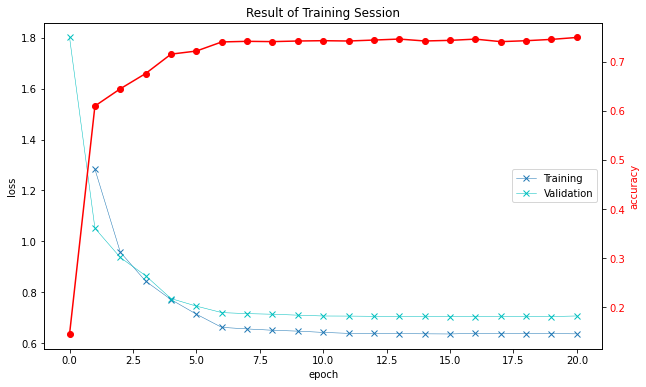

In [37]:
plot_result(history_CNN)

### Test the model

First, let's test with some invidiual images.

Target: mountain
Prediction: mountain


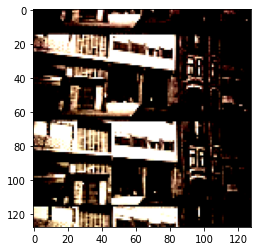

In [55]:
# Test 1
show_image_prediction(*test_ds[300], model_CNN)

Target: glacier
Prediction: glacier


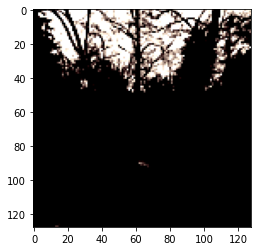

In [56]:
# Test 2
show_image_prediction(*test_ds[900], model_CNN)

Target: sea
Prediction: buildings


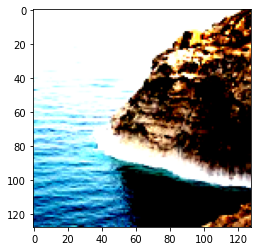

In [79]:
# Test 3
show_image_prediction(*test_ds[2100], model_CNN)

Finally, evaluate the model with the entire test set.

In [48]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2, num_workers=2), device)

result_CNN = evaluate(model_CNN, test_dl)
result_CNN

{'val_acc': 0.7551941871643066, 'val_loss': 0.6959465742111206}

Confusion Matrix

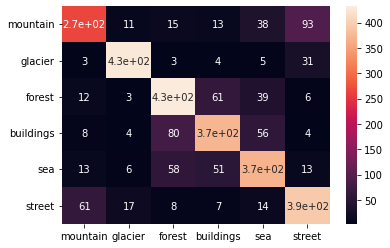

In [49]:
cfs_mat(model_CNN)

### Record result and save the model

In [59]:
model_results['model'].append('CNN')
model_results['val_acc'].append(result_CNN['val_acc'])
torch.save(model_CNN.state_dict(), 'intel_image-cnn.pth')

In [62]:
jovian.set_project('intel-image-classification')
jovian.set_colab_id('1cggXsaBkCRm4y-kDuvfCuGyWbQq-9L_8')

In [ ]:
jovian.log_hyperparams(arch='CNN')
jovian.log_metrics(test_loss=result_CNN['val_loss'], test_acc=result_CNN['val_acc'])
jovian.commit(project=project_name)

## ResNet9

### Construct the model

We will use the ResNet9 architecture to build our main model.

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [21]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        #prep
        self.conv1 = conv_block(in_channels, 32)     # out: 32*128*128

        #layer1
        self.conv2 = conv_block(32, 64, pool=2)      # 64*64*64
        self.res1 = nn.Sequential(conv_block(64, 64), 
                                  conv_block(64, 64))
        
        #layer 2
        self.conv3 = conv_block(64, 128, pool=2)     # 128*32*32

        #layer 3
        self.conv4 = conv_block(128, 256, pool=2)    # 256*16*16
        self.res2 = nn.Sequential(conv_block(256, 256), 
                                  conv_block(256, 256))
        
        #classifier
        self.clf = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 256*1*1
                                 nn.Flatten(), 
                                 nn.Dropout(0.2), 
                                 nn.Linear(256, num_classes))
        
    def forward(self, batch):
        out = self.conv1(batch)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.clf(out)
        return out

In [65]:
model_RN9 = to_device(ResNet9(3, num_classes), device)

Instead of using previous `fit` function, we will upgrade it to `fit_one_cycle` function with some small yet important improvements:

- **Learning rate scheduler** (`lr_sched`): Instead of using a fixed learning rate, we will use a learning rate scheduler called [**One Cycle Learning Rate Policy**](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), which will change the learning rate after every batch of training by starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

- **Weight decay** (`weight_decay`): We also use weight decay which prevents the weights from becoming too large by adding an additional term to the loss function.

- **Gradient clipping** (`grad_clip`): Gradient clipping is a simple yet effective technique which helps to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values.

In [22]:
def fit_one_cycle(model, train_loader, val_loader, 
                  epochs, max_lr, opt_func=torch.optim.SGD, 
                  grad_clip=None, weight_decay=0):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                   steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Update learning rate
            lr_sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training Process

In [68]:
history_RN9 = [evaluate(model_RN9, valid_dl)]
history_RN9

[{'val_acc': 0.18335026502609253, 'val_loss': 1.7887685298919678}]

In [69]:
# Run 1
epochs = 5
max_lr = 0.01
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 1e-3

history_RN9 += fit_one_cycle(model_RN9, train_dl, valid_dl, 
                             epochs, max_lr, opt_func, 
                             grad_clip, weight_decay)

Epoch [0]: train_loss: 1.0391, val_loss: 0.7086, val_acc: 0.7348
Epoch [1]: train_loss: 0.7178, val_loss: 1.0532, val_acc: 0.6301
Epoch [2]: train_loss: 0.6709, val_loss: 1.1493, val_acc: 0.6227
Epoch [3]: train_loss: 0.6199, val_loss: 0.5849, val_acc: 0.7783
Epoch [4]: train_loss: 0.5278, val_loss: 0.4424, val_acc: 0.8353
Epoch [5]: train_loss: 0.4712, val_loss: 0.6200, val_acc: 0.7762
Epoch [6]: train_loss: 0.4243, val_loss: 0.4711, val_acc: 0.8287
Epoch [7]: train_loss: 0.3460, val_loss: 0.3363, val_acc: 0.8852
Epoch [8]: train_loss: 0.2759, val_loss: 0.3054, val_acc: 0.8966
Epoch [9]: train_loss: 0.2276, val_loss: 0.2876, val_acc: 0.9056


In [71]:
# Run 2
epochs = 5
max_lr = 1e-3
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 1e-3

history_RN9 += fit_one_cycle(model_RN9, train_dl, valid_dl, 
                             epochs, max_lr, opt_func, 
                             grad_clip, weight_decay)

Epoch [0]: train_loss: 0.2376, val_loss: 0.4481, val_acc: 0.8386
Epoch [1]: train_loss: 0.2881, val_loss: 0.3812, val_acc: 0.8597
Epoch [2]: train_loss: 0.2694, val_loss: 0.4279, val_acc: 0.8489
Epoch [3]: train_loss: 0.2140, val_loss: 0.2944, val_acc: 0.8971
Epoch [4]: train_loss: 0.1634, val_loss: 0.2735, val_acc: 0.9116


In [84]:
# Run 3
epochs = 5
max_lr = 1e-4
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 1e-3

history_RN9 += fit_one_cycle(model_RN9, train_dl, valid_dl, 
                             epochs, max_lr, opt_func, 
                             grad_clip, weight_decay)

Epoch [0]: train_loss: 0.1518, val_loss: 0.2728, val_acc: 0.9122
Epoch [1]: train_loss: 0.1477, val_loss: 0.2847, val_acc: 0.9025
Epoch [2]: train_loss: 0.1367, val_loss: 0.2792, val_acc: 0.9123
Epoch [3]: train_loss: 0.1258, val_loss: 0.2713, val_acc: 0.9090
Epoch [4]: train_loss: 0.1210, val_loss: 0.2751, val_acc: 0.9103


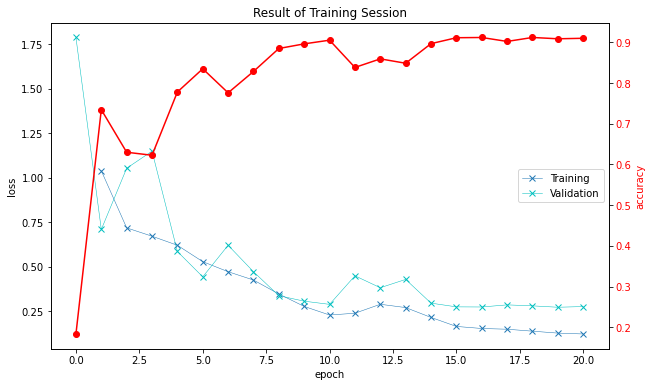

In [85]:
plot_result(history_RN9)

### Test the model

First, let's test with some invidiual images.

Target: mountain
Prediction: mountain


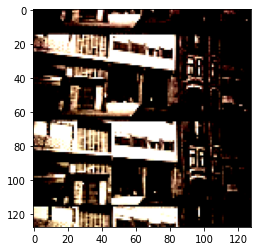

In [80]:
# Test 1
show_image_prediction(*test_ds[300], model_RN9)

Target: glacier
Prediction: glacier


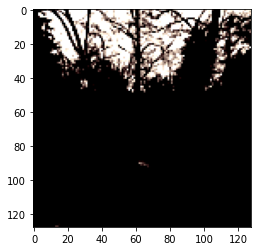

In [81]:
# Test 2
show_image_prediction(*test_ds[900], model_RN9)

Target: sea
Prediction: sea


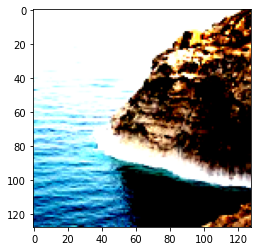

In [82]:
# Test 3
show_image_prediction(*test_ds[2100], model_RN9)

Finally, evaluate the model with the entire test set.

In [86]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2, num_workers=2), device)

result_RN9 = evaluate(model_RN9, test_dl)
result_RN9

{'val_acc': 0.8995838761329651, 'val_loss': 0.28254181146621704}

Confusion Matrix

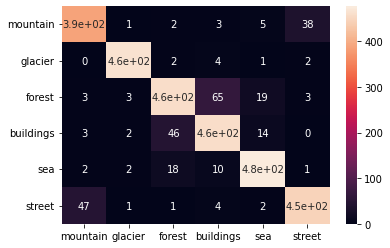

In [92]:
cfs_mat(model_RN9)

### Record result and save the model

In [90]:
model_results['model'].append('ResNet9')
model_results['val_acc'].append(result_RN9['val_acc'])
torch.save(model_CNN.state_dict(), 'intel_image-resnet9.pth')


In [ ]:
jovian.log_hyperparams(arch='ResNet9')
jovian.log_metrics(test_loss=result_RN9['val_loss'], test_acc=result_RN9['val_acc'])
jovian.commit(project=project_name)

## Transfer Learning

Import a Pretrained Model (ResNet34)

In [23]:
class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, batch):
        return self.network(batch)

In [24]:
model_RN34 = to_device(ResNet34(num_classes, pretrained=True), device)

In [25]:
history_RN34 = [evaluate(model_RN34, valid_dl)]
history_RN34

[{'val_acc': 0.1002974733710289, 'val_loss': 2.1193149089813232}]

In [26]:
# Run 1
epochs = 5
max_lr = 0.01
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 1e-3

history_RN34 += fit_one_cycle(model_RN34, train_dl, valid_dl, 
                              epochs, max_lr, opt_func, 
                              grad_clip, weight_decay)

Epoch [0]: train_loss: 0.5751, val_loss: 5.0858, val_acc: 0.1993
Epoch [1]: train_loss: 0.8669, val_loss: 1.2297, val_acc: 0.4835
Epoch [2]: train_loss: 0.5904, val_loss: 0.7830, val_acc: 0.7205
Epoch [3]: train_loss: 0.4891, val_loss: 0.5408, val_acc: 0.8125
Epoch [4]: train_loss: 0.3253, val_loss: 0.3492, val_acc: 0.8878


In [27]:
# Run 2
epochs = 5
max_lr = 0.001
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 5e-3

history_RN34 += fit_one_cycle(model_RN34, train_dl, valid_dl, 
                              epochs, max_lr, opt_func, 
                              grad_clip, weight_decay)

Epoch [0]: train_loss: 0.3011, val_loss: 0.5122, val_acc: 0.8277
Epoch [1]: train_loss: 0.3737, val_loss: 0.5113, val_acc: 0.8281
Epoch [2]: train_loss: 0.3542, val_loss: 0.7039, val_acc: 0.7582
Epoch [3]: train_loss: 0.2833, val_loss: 0.3468, val_acc: 0.8859
Epoch [4]: train_loss: 0.2157, val_loss: 0.3056, val_acc: 0.9015


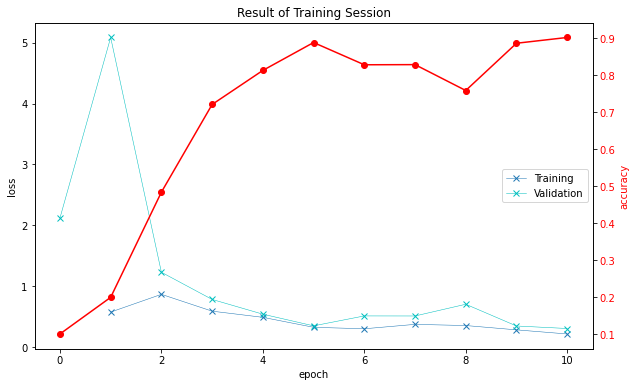

In [29]:
plot_result(history_RN34)

In [30]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2, num_workers=2), device)

result_RN34 = evaluate(model_RN34, test_dl)
result_RN34

{'val_acc': 0.903957188129425, 'val_loss': 0.28132402896881104}

In [32]:
model_results['model'].append('ResNet34')
model_results['val_acc'].append(result_RN34['val_acc'])
torch.save(model_RN34.state_dict(), 'intel_image-resnet34.pth')

In [36]:
jovian.log_hyperparams(arch='ResNet34')
jovian.log_metrics(test_loss=result_RN34['val_loss'], test_acc=result_RN34['val_acc'])
jovian.commit(project=project_name)

[jovian] Hyperparams logged.
[jovian] Metrics logged.
[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/f2l2804nk/intel-image-classification


'https://jovian.ai/f2l2804nk/intel-image-classification'

## Summary and Further Reading

You are now ready to train state-of-the-art deep learning models from scratch. Try working on a project on your own by following these guidelines: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project

Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:


* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. [Learn more](https://medium.com/@ml_kid/what-is-transform-and-transform-normalize-lesson-4-neural-networks-in-pytorch-ca97842336bd)

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. [Learn more](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the ResNet9 architecture [Learn more](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec).

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. [Learn more](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are [many strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy". [Learn more](https://sgugger.github.io/the-1cycle-policy.html)

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. [Learn more](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab)

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  [Learn more.](https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48#63e0)

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. [Learn more.](https://ruder.io/optimizing-gradient-descent/index.html)


As an exercise, you should try applying each technique independently and see how much each one affects the performance and training time. As you try different experiments, you will start to cultivate the intuition for picking the right architectures, data augmentation & regularization techniques.

You are now ready to move on to the next tutorial in this series: [Generating Images using Generative Adversarial Networks](https://jovian.ai/aakashns/06b-anime-dcgan/)
